In [1]:
# Created on Fri Nov 30 2018
# author: Tianyuan Huang
# Todo: using Node2vec and Word2vec model to train sampled data

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import csv
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from spherecluster import SphericalKMeans
import seaborn as sns
import hdbscan as hd
import networkx as nx
from node2vec import Node2Vec
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim.models.word2vec as w2v
import sklearn.manifold

C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load clean and translated data
raw_data = pd.read_csv(r"C:\Users\Administrator\Desktop\Research\Debug\11.29\traj_clean.csv")
df_clean = pd.DataFrame(raw_data)
df_clean.columns = ['id', 'user_id', 'poi_zh','time', 'poi_id','user_index', 'poi_en']
print(df_clean)

        id  user_id      poi_zh   time  poi_id  user_index  \
0        1        6     房地产;写字楼  31900      46           0   
1        2        6  政府机构;公检法机构   9035      51           0   
2        3        6     行政地标;村庄  17361     122           0   
3        4       12     房地产;住宅区   9003      44           2   
4        5       12      美食;中餐厅   1779     113           2   
5        6       13     房地产;住宅区  19329      44           3   
6        7       13     房地产;写字楼   1933      46           3   
7        8       13    旅游景点;风景区   2638      86           3   
8        9       14     房地产;住宅区   1188      44           4   
9       10       14     房地产;写字楼  26626      46           4   
10      11       14      美食;中餐厅     42     113           4   
11      12       14   生活服务;物流公司     67     108           4   
12      13       14     美食;外国餐厅   5389     116           4   
13      14       14    美食;蛋糕甜品店    180     119           4   
14      15       14       购物;商铺  17556     126           4   
15      

### Part1 Node2vec

In [3]:
# Draw overall graph
G = nx.Graph()
num = df_clean.shape[0]
for i in range(1, num):
    G.add_edge(df_clean.user_id[i], df_clean.poi_en[i])

C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


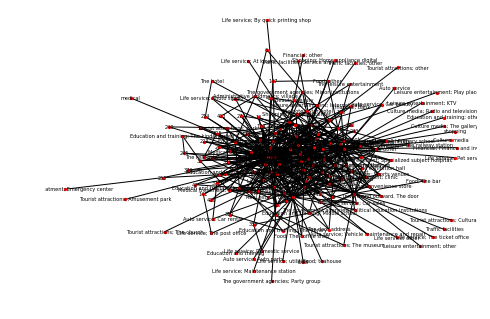

In [4]:
# Visualize 500 edges
G_test = nx.Graph()
for i in range(1, 500):
    G_test.add_edge(df_clean.user_id[i], df_clean.poi_en[i])
nx.draw(G_test,node_size = 5, with_labels=True, font_size=5, font_family='sans-serif')

In [5]:
# Collect POI
locations = set(df_clean.poi_en.unique())

In [6]:
# Train
node2vec = Node2Vec(G, dimensions=256, walk_length=64, num_walks=100, workers=2)

Computing transition probabilities: 100%|███████████████████████████████████████████| 699/699 [00:01<00:00, 381.24it/s]


In [7]:
# Dimension reduction
model = node2vec.fit(window=10, min_count=1)
user_nodes = [x for x in model.wv.vocab if x not in locations]
location_nodes = [x for x in model.wv.vocab if x in locations]
embeddings = np.array([model.wv[x] for x in user_nodes])
embeddings_locations = np.array([model.wv[x] for x in location_nodes])
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)
embeddings_locations_2d = tsne.fit_transform(embeddings_locations)

In [8]:
# Plot user nodes and POI nodes
count = len(embeddings_2d)
count_locations = len(embeddings_locations_2d)
x = []
y = []
user_id = []
for item in user_nodes:
    user_id.append(item)    
for coords in embeddings_2d:
    x.append(coords[0]) 
    y.append(coords[1])
final_data = []
for i in range(count):
    item = [user_id[i], x[i], y[i]]
    final_data.append(item)
x_l = []
y_l = []
location_id = []
for item in location_nodes:
    location_id.append(item)   
for coords in embeddings_locations_2d:
    x_l.append(coords[0]) 
    y_l.append(coords[1])
location_data = []
for i in range(len(location_nodes)):
    item = [location_id[i], x_l[i], y_l[i]]
    location_data.append(item)

In [11]:
location_points = pd.DataFrame(
    data = location_data, columns=["id", "x", "y"]
)
points = pd.DataFrame(
    data = final_data, columns=["id", "x", "y"]
)
merge_points = points.append(location_points)

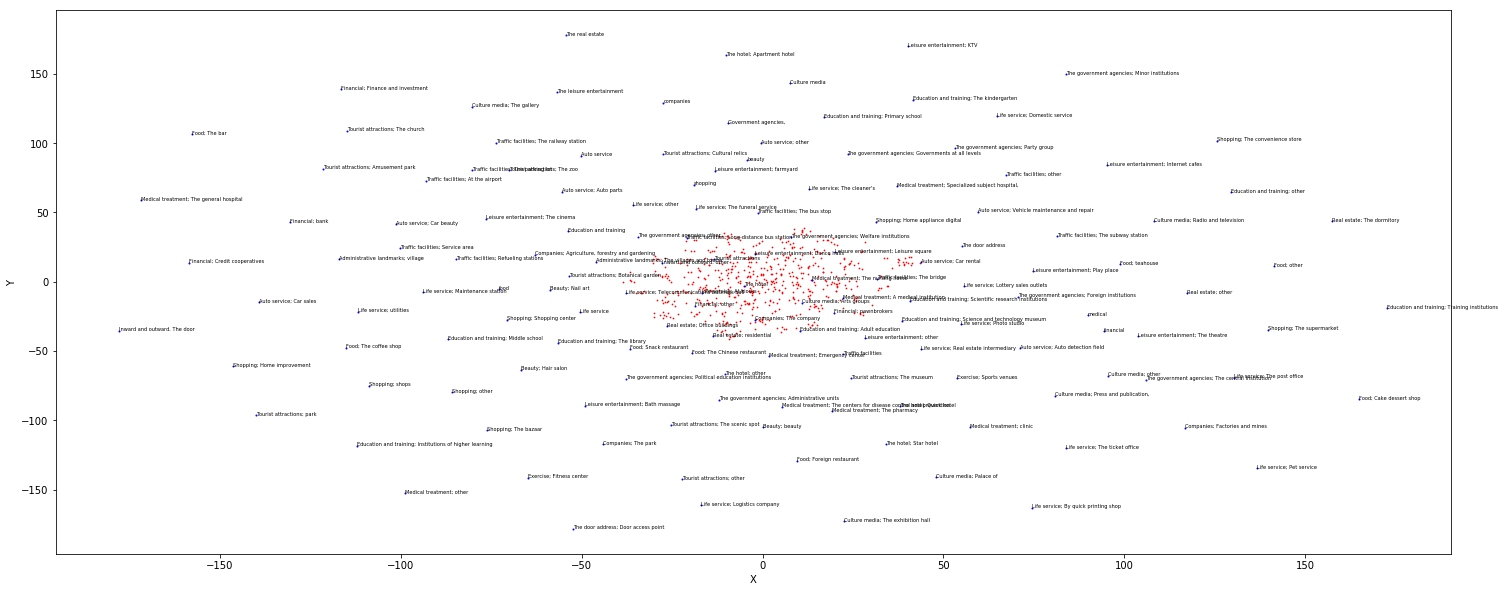

In [12]:
# Visualize user nodes and POI nodes
figure = plt.figure(figsize=(25, 10))
axes = figure.add_subplot(111)
axes.scatter(points.x, points.y,color = 'red', s = 0.5)
axes.scatter(location_points.x, location_points.y, color='blue', s = 1)

for i, txt in enumerate(location_id):
    axes.annotate(txt, (location_points.x[i], location_points.y[i]), fontsize = 5)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Part2 Word2vec

In [13]:
# Collect trajectories for each individuals
names = "traj_word2vec.csv"
f = open(names, 'w', newline='',encoding='utf-8')
writer = csv.writer(f, dialect='excel')

change_line = []
num = df_clean.shape[0]
for i in range(1,num):
    if(df_clean.user_id[i] != df_clean.user_id[i-1]):
        change_line.append(i)
user_num = len(change_line)
print(user_num)

for i in range(user_num-1):
    traj = []
    for item in range(change_line[i], change_line[i+1]):
        traj.append(df_clean.poi_en[item])
    writer.writerow([i, traj])
    print([i, traj])

551
[0, ['Real estate; residential', 'Food; The Chinese restaurant']]
[1, ['Real estate; residential', 'Real estate; Office buildings', 'Tourist attractions; The scenic spot']]
[2, ['Real estate; residential', 'Real estate; Office buildings', 'Food; The Chinese restaurant', 'Life service; Logistics company', 'Food; Foreign restaurant', 'Food; Cake dessert shop', 'Shopping; shops', 'The hotel; other']]
[3, ['Real estate; residential', 'Real estate; Office buildings', 'Companies; The park', 'Medical treatment; The general hospital', 'Education and training; The kindergarten']]
[4, ['Real estate; residential', 'Education and training; Institutions of higher learning', 'Food; Snack restaurant']]
[5, ['Real estate; residential', 'Food; Snack restaurant', 'Shopping; Home improvement']]
[6, ['Real estate; residential', 'Real estate; Office buildings', 'Companies; The company', 'Shopping; The bazaar', 'Shopping; Home improvement', 'Traffic facilities; Refueling stations', 'Traffic facilities; 

[61, ['Real estate; residential', 'Real estate; Office buildings', 'Administrative landmarks; village']]
[62, ['Real estate; residential', 'Food; Cake dessert shop']]
[63, ['Real estate; residential', 'Food; The Chinese restaurant', 'Shopping; shops', 'The government agencies; Administrative units']]
[64, ['Real estate; residential', 'Shopping; The bazaar', 'Leisure entertainment; Internet cafes']]
[65, ['Real estate; residential', 'Companies; The company', 'Education and training; Training institutions']]
[66, ['Real estate; residential', 'Companies; The company']]
[67, ['Real estate; residential', 'Companies; The park']]
[68, ['Real estate; residential', 'Food; Snack restaurant', 'Education and training; Training institutions']]
[69, ['Real estate; residential', 'Life service; utilities']]
[70, ['Real estate; residential', 'Food; Cake dessert shop', 'Inward and outward. The door']]
[71, ['Real estate; residential', 'Shopping; The supermarket']]
[72, ['Real estate; residential', 'Real

[112, ['Real estate; residential', 'Tourist attractions; The scenic spot', 'The hotel; other', 'Traffic facilities; Refueling stations', 'Real estate; other', 'Exercise; Sports venues', 'The hotel; Apartment hotel']]
[113, ['Real estate; residential', 'Education and training; Institutions of higher learning']]
[114, ['Real estate; residential', 'Food; The Chinese restaurant', 'Education and training; The kindergarten', 'Leisure entertainment; Bath massage', 'The hotel; Quick hotel', 'Leisure entertainment; KTV', 'Food; other']]
[115, ['Real estate; residential', 'Real estate; Office buildings']]
[116, ['Real estate; residential', 'Real estate; Office buildings', 'Education and training; Institutions of higher learning', 'Education and training; other', 'The hotel; Apartment hotel', 'Shopping; other']]
[117, ['Real estate; residential', 'Real estate; Office buildings', 'The government agencies; Minor institutions', 'Administrative landmarks; village', 'The real estate', 'Culture media; 

[147, ['Real estate; residential', 'Real estate; Office buildings', 'The government agencies; Minor institutions', 'Food; The Chinese restaurant', 'Shopping; The supermarket', 'Life service; Logistics company', 'Food; Cake dessert shop', 'Shopping; shops', 'The hotel; other', 'Companies; The park', 'Medical treatment; The general hospital', 'Food; Snack restaurant', 'Companies; The company', 'Medical treatment; The pharmacy', 'Shopping; The bazaar', 'Shopping; Home improvement', 'Traffic facilities; Refueling stations', 'Leisure entertainment; Bath massage', 'Medical treatment; clinic', 'The government agencies; Governments at all levels', 'Beauty; Hair salon', 'Medical treatment; other', 'The government agencies; Administrative units', 'Education and training; other', 'Tourist attractions; park', 'Auto service; Car sales', 'Life service; Pet service', 'Shopping; The convenience store', 'Exercise; Sports venues', 'The hotel; Apartment hotel', 'The door address; Door access point', 'The

[191, ['Real estate; residential', 'Food; The Chinese restaurant', 'Shopping; shops', 'Exercise; Sports venues', 'Shopping; other']]
[192, ['Real estate; residential', 'Food; The Chinese restaurant', 'Medical treatment; The general hospital', 'Food; Snack restaurant', 'Life service; Maintenance station']]
[193, ['Real estate; residential', 'Leisure entertainment; Play place']]
[194, ['Real estate; residential', 'Education and training; Training institutions', 'Shopping; Shopping center', 'Education and training; Middle school']]
[195, ['Real estate; residential', 'Education and training; The kindergarten', 'Education and training; Primary school', 'Inward and outward. The door']]
[196, ['Real estate; residential', 'Real estate; Office buildings', 'Auto service; Car beauty', 'Education and training; Institutions of higher learning', 'Medical treatment; The pharmacy', 'Education and training; Scientific research institutions', 'Food; other', 'Companies; Agriculture, forestry and gardenin

[280, ['Real estate; residential', 'Life service; The post office']]
[281, ['Real estate; residential', 'Real estate; Office buildings', 'Tourist attractions; The scenic spot', 'The hotel; other', 'Education and training; The kindergarten', 'Food; Snack restaurant', 'Traffic facilities; The railway station', 'Medical treatment; Specialized subject hospital,', 'Medical treatment; other', 'The government agencies; Administrative units', 'Tourist attractions; park', 'Exercise; Sports venues', 'Education and training; Middle school', 'Shopping; other', 'Real estate; The dormitory']]
[282, ['Real estate; residential', 'Food; The Chinese restaurant', 'Tourist attractions; park']]
[283, ['Real estate; residential', 'Companies; The company', 'Education and training; other']]
[284, ['Real estate; residential', 'Real estate; Office buildings']]
[285, ['Real estate; residential', 'Medical treatment; The pharmacy']]
[286, ['Real estate; residential', 'Administrative landmarks; village', 'Food; The

[331, ['Real estate; residential', 'Real estate; Office buildings', 'Food; The Chinese restaurant', 'Shopping; The supermarket', 'Tourist attractions; The scenic spot', 'Life service; Logistics company', 'Shopping; shops', 'The hotel; other', 'Auto service; Car beauty', 'Medical treatment; The general hospital', 'Education and training; Institutions of higher learning', 'Food; Snack restaurant', 'Companies; The company', 'Medical treatment; The pharmacy', 'Traffic facilities; Refueling stations', 'Leisure entertainment; Bath massage', 'Leisure entertainment; Internet cafes', 'Medical treatment; clinic', 'The government agencies; Governments at all levels', 'Life service; Telecommunications business hall', 'The hotel; Quick hotel', 'Financial; bank', 'Beauty; Hair salon', 'Beauty; beauty', 'Leisure entertainment; KTV', 'Medical treatment; other', 'Real estate; other', 'The government agencies; Administrative units', 'Auto service; Car sales', 'Life service; Pet service', 'shopping', 'Sh

[399, ['Real estate; residential', 'Real estate; Office buildings', 'Shopping; shops']]
[400, ['Real estate; residential', 'Shopping; The supermarket', 'Shopping; shops', 'Companies; The company', 'Medical treatment; The pharmacy', 'Shopping; The bazaar', 'Education and training; Primary school', 'Leisure entertainment; Bath massage', 'Life service; Pet service', 'Shopping; The convenience store', 'Life service; Photo studio']]
[401, ['Real estate; residential', 'Real estate; Office buildings', 'Food; The Chinese restaurant', 'Tourist attractions; The scenic spot', 'Shopping; shops', 'The hotel; other', 'Medical treatment; The general hospital', 'Shopping; The bazaar', 'Leisure entertainment; Bath massage', 'Financial; bank', 'Medical treatment; other', 'The government agencies; Administrative units', 'Tourist attractions; The museum', 'Education and training', 'Real estate; The dormitory', 'Leisure entertainment; The theatre']]
[402, ['Real estate; residential', 'The real estate', 'Sh

[469, ['The government agencies; Minor institutions', 'Food; The Chinese restaurant', 'Shopping; The supermarket', 'Tourist attractions; The scenic spot', 'Shopping; The bazaar', 'Leisure entertainment; Internet cafes', 'Life service; Telecommunications business hall', 'Beauty; beauty', 'Shopping; Shopping center', 'Tourist attractions; Cultural relics', 'food']]
[470, ['The government agencies; Minor institutions', 'Leisure entertainment; Bath massage']]
[471, ['Administrative landmarks; village', 'Tourist attractions; park', 'Life service; Photo studio']]
[472, ['The real estate', 'Culture media; The exhibition hall', 'Food; The Chinese restaurant', 'Food; The bar', 'Shopping; The supermarket']]
[473, ['The real estate', 'Shopping; The convenience store', 'Food; other']]
[474, ['The real estate', 'Culture media; The exhibition hall', 'Food; The Chinese restaurant', 'Tourist attractions; The scenic spot', 'Food; Snack restaurant', 'Companies; The company', 'The hotel; Quick hotel', 'T

In [16]:
# Use excel to format traj_word2vec.csv to traj_word2vec_clean.csv and load tokenized data
data = pd.read_csv(r"C:\Users\Administrator\Desktop\Research\Debug\11.29\traj_word2vec_clean.csv")
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
print(tagged_data)

[TaggedDocument(words=['real_estate_residential', 'food_the_chinese_restaurant'], tags=['0']), TaggedDocument(words=['real_estate_residential', 'real_estate_office_buildings', 'tourist_attractions_the_scenic_spot'], tags=['1']), TaggedDocument(words=['real_estate_residential', 'real_estate_office_buildings', 'food_the_chinese_restaurant', 'life_service_logistics_company', 'food_foreign_restaurant', 'food_cake_dessert_shop', 'shopping_shops', 'the_hotel_other'], tags=['2']), TaggedDocument(words=['real_estate_residential', 'real_estate_office_buildings', 'companies_the_park', 'medical_treatment_the_general_hospital', 'education_and_training_the_kindergarten'], tags=['3']), TaggedDocument(words=['real_estate_residential', 'education_and_training_institutions_of_higher_learning', 'food_snack_restaurant'], tags=['4']), TaggedDocument(words=['real_estate_residential', 'food_snack_restaurant', 'shopping_home_improvement'], tags=['5']), TaggedDocument(words=['real_estate_residential', 'real_e

In [17]:
# Doc2vec training
max_epochs = 100
vec_size = 20
alpha = 0.025
model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
model.build_vocab(tagged_data)
for epoch in range(max_epochs):
    model.train(tagged_data, total_examples = model.corpus_count, epochs = model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
model.save("d2v.model")
print("Model Saved")

C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\gensim\models\doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


Model Saved


In [19]:
# Dimension reduction for trajectories representation
from gensim.models.doc2vec import Doc2Vec
model= Doc2Vec.load("d2v.model")
count = 523
vector = []
for i in range(count):
    vector.append(model.docvecs[i])
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
vectors_matrix_2d = tsne.fit_transform(vector)

In [20]:
# Dimension reduction for POIs
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [23]:
# Plot embedding results of POIs
xp = []
yp = []
poi = []
for item in vocab:
    poi.append(item)  
for coords in X_tsne:
    xp.append(coords[0]) 
    yp.append(coords[1])
poi_data = []
for i in range(len(vocab)):
    item = [poi[i], xp[i], yp[i]]
    poi_data.append(item)
poi_points = pd.DataFrame(
    data = poi_data, columns=["trajectories", "x", "y"]
)
# Plot embedding results of user trajectories
x = []
y = []
traj = []
for item in data:
    traj.append(item)
for coords in vectors_matrix_2d:
    x.append(coords[0]) 
    y.append(coords[1])
final_data = []
for i in range(count):
    item = [traj[i], x[i], y[i]]
    final_data.append(item)
points = pd.DataFrame(
    data = final_data, columns=["trajectories", "x", "y"]
)

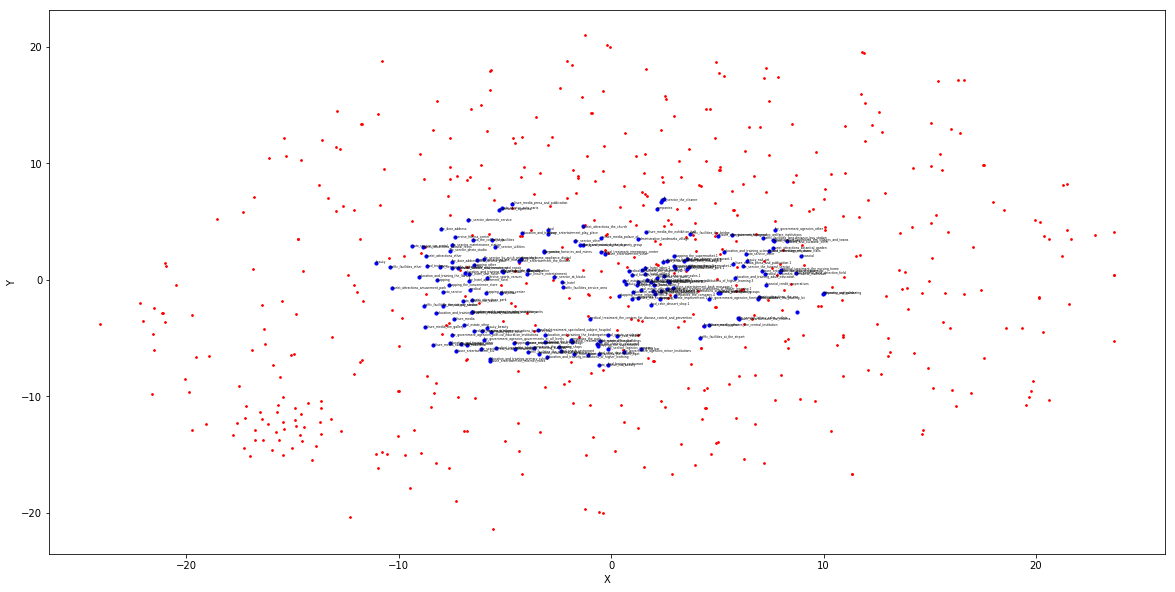

In [25]:
# Visualize embedding results of POIs and user trajectoris
figure = plt.figure(figsize=(20, 10))
axes = figure.add_subplot(111)
axes.scatter(points.x, points.y,color = 'red', s = 3)
axes.scatter(poi_points.x, poi_points.y, color='blue', s = 10)

for i, txt in enumerate(vocab):
    axes.annotate(txt, (poi_points.x[i], poi_points.y[i]), fontsize = 3)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()